In [1]:
import torch
import torch.utils.data
import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
from tqdm import tqdm
from PIL import Image, ImageOps

import torch.nn as nn

import MathNet as mnt

In [2]:
BATCH_SIZE = 128
EPOCHS = 41

In [5]:
# the training transforms
train_transform = transforms.Compose([
    transforms.Grayscale(1),
    transforms.ToTensor()
    #transforms.Normalize(std=0.5, mean=0.2)
    
])
# the validation transforms
valid_transform = transforms.Compose([
    transforms.Grayscale(1),
    transforms.ToTensor()
])

In [6]:
dataset = torchvision.datasets.ImageFolder(r'TRAIN\all_dataset224', transform=train_transform)
print(len(dataset))

338219


In [7]:
classes_dict = dataset.class_to_idx
classes = []
for key in classes_dict.keys():
    classes.append(str(key))
classes.sort()
classes

['(',
 ')',
 '+',
 ',',
 '-',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'A',
 'F',
 'alpha',
 'and',
 'beta',
 'delta',
 'exists',
 'forall',
 'gamma',
 'lambda',
 'mu',
 'not',
 'omega',
 'or',
 'phi',
 'pi',
 'psi',
 'rightarrow',
 'sigma',
 'tau',
 'theta',
 'upsilon',
 'x',
 'y',
 'z']

In [8]:
# classes = ['(', ')', ',', '-', 
#                    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 
#                    'A', '[', 'α', 'and', 'β', '∃', 'F', '∀', 
#                    'γ', 'λ', 'μ', 'ω', 'or', 'φ', '→', 
#                    'σ', 'sqrt', 'θ', 'v', 'x', 'y', 'z']

NUM_CLASSES = len(classes)

def map_pred(ind):
    if ind < NUM_CLASSES:
        return classes[ind]
    return 'ERROR MAPPIMG'

NUM_CLASSES

40

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
device

device(type='cuda', index=0)

In [12]:
def add_contrast(x, factor):
    return transforms.functional.adjust_contrast(x, factor)

In [13]:
mean, std = dataset[0][0].mean(), dataset[0][0].std()
print(mean, std)

tensor(0.7992) tensor(0.3780)


In [14]:
def train_val_dataset(dataset, val_split=0.2):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

In [15]:
datasets = train_val_dataset(dataset)
print(type(datasets['train']))
print(len(datasets['val']))
# The original dataset is avail


<class 'torch.utils.data.dataset.Subset'>
67644


In [16]:
print(dataset)

Dataset ImageFolder
    Number of datapoints: 338219
    Root location: TRAIN\all_dataset224
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               ToTensor()
           )


67644


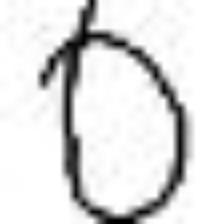

In [17]:
# training dataset
train_dataset = datasets['train']
# validation dataset
valid_dataset = (datasets['val'])
# training data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=6, pin_memory=True
)
# validation data loaders
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=6, pin_memory=True
)
# training data loaders
dataset[0]
print(len(valid_dataset))
#print(valid_dataset.dataset.targets)
aaa = transforms.ToPILImage()
display(aaa(valid_dataset[15451][0]))

In [18]:
from collections import Counter


In [19]:
d = dict(Counter(valid_dataset.dataset.targets))
print(d)

{0: 14293, 1: 14355, 2: 9464, 3: 1906, 4: 15834, 5: 12836, 6: 16968, 7: 11884, 8: 11760, 9: 14853, 10: 12589, 11: 8749, 12: 12158, 13: 12189, 14: 9976, 15: 14407, 16: 7480, 17: 7284, 18: 5634, 19: 5421, 20: 1246, 21: 5896, 22: 16053, 23: 2861, 24: 1105, 25: 1623, 26: 10350, 27: 12527, 28: 5043, 29: 3806, 30: 5775, 31: 1115, 32: 4140, 33: 1525, 34: 608, 35: 6918, 36: 3506, 37: 17559, 38: 9454, 39: 7069}


<AxesSubplot:ylabel='Сharactrs'>

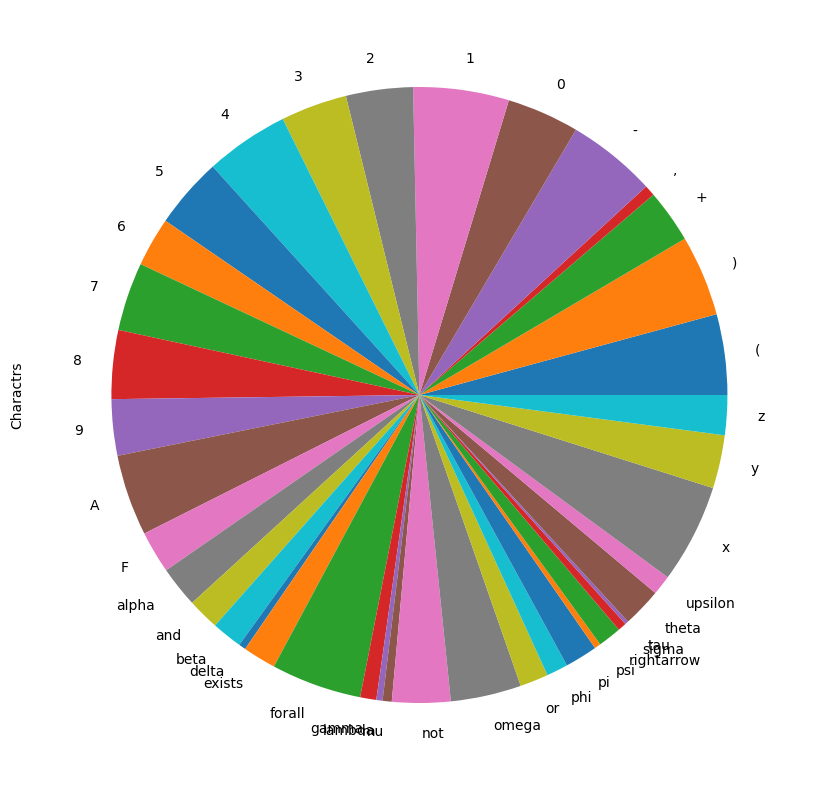

In [20]:
import pandas as pd
df = pd.Series(data=d,name='Сharactrs')    
df.plot(labels=classes,kind='pie',figsize=(10,10))

In [21]:
# training
def train(model, trainloader, optimizer, loss_function):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=int(len(trainloader))):
        counter += 1
        optimizer.zero_grad()
        x, y = data
        x = x.to(device)      
        y = y.to(device)       
        outputs = model.forward(x)
        loss = loss_function(outputs, y)
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == y).sum().item()
        loss.backward()
        optimizer.step()
    
    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

In [22]:
def validate(model, testloader, loss_function):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=int(len(testloader))):
            counter += 1
            x, y = data
            x = x.to(device)      
            y = y.to(device)
            # forward pass
            outputs = model(x)
            # calculate the loss
            loss = loss_function(outputs, y)
            valid_running_loss += loss.item()
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == y).sum().item()
        
    # loss and accuracy for the complete epoch
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

In [23]:
model = mnt.MathNet()
torch.cuda.empty_cache()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
model = model.to(device)
device
type(model)

__main__.MathNet

In [24]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-4)

In [25]:
def save_plots(train_acc, valid_acc, train_loss, valid_loss, label=''):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='-', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-', 
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('outputs/mathnet_accuracy'+label+'.png')
    
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('outputs/mathnet_loss'+label+'.png')

[INFO]: Epoch 1 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:55<00:00,  5.95it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [01:13<00:00,  7.18it/s]


Training loss: 0.214, training acc: 94.745
Validation loss: 0.087, validation acc: 97.460
--------------------------------------------------
[INFO]: Epoch 2 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:56<00:00,  5.94it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:28<00:00, 18.69it/s]


Training loss: 0.082, training acc: 97.654
Validation loss: 0.074, validation acc: 97.945
--------------------------------------------------
[INFO]: Epoch 3 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:56<00:00,  5.92it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:26<00:00, 19.64it/s]


Training loss: 0.067, training acc: 98.057
Validation loss: 0.070, validation acc: 97.969
--------------------------------------------------
[INFO]: Epoch 4 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:43<00:00,  6.15it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:26<00:00, 19.73it/s]


Training loss: 0.059, training acc: 98.240
Validation loss: 0.065, validation acc: 98.072
--------------------------------------------------
[INFO]: Epoch 5 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:43<00:00,  6.16it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:26<00:00, 19.71it/s]


Training loss: 0.051, training acc: 98.459
Validation loss: 0.062, validation acc: 98.165
--------------------------------------------------
[INFO]: Epoch 6 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:44<00:00,  6.14it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:26<00:00, 19.64it/s]


Training loss: 0.046, training acc: 98.586
Validation loss: 0.055, validation acc: 98.399
--------------------------------------------------
[INFO]: Epoch 7 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:45<00:00,  6.12it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:26<00:00, 19.71it/s]


Training loss: 0.042, training acc: 98.676
Validation loss: 0.044, validation acc: 98.696
--------------------------------------------------
[INFO]: Epoch 8 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:45<00:00,  6.12it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:26<00:00, 19.63it/s]


Training loss: 0.038, training acc: 98.796
Validation loss: 0.053, validation acc: 98.437
--------------------------------------------------
[INFO]: Epoch 9 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:45<00:00,  6.11it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:26<00:00, 19.63it/s]


Training loss: 0.035, training acc: 98.885
Validation loss: 0.282, validation acc: 91.343
--------------------------------------------------
[INFO]: Epoch 10 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:47<00:00,  6.08it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:28<00:00, 18.73it/s]


Training loss: 0.032, training acc: 98.988
Validation loss: 0.050, validation acc: 98.505
--------------------------------------------------
[INFO]: Epoch 11 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:59<00:00,  5.88it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:28<00:00, 18.77it/s]


Training loss: 0.030, training acc: 99.041
Validation loss: 0.035, validation acc: 98.964
--------------------------------------------------
[INFO]: Epoch 12 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:59<00:00,  5.87it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:28<00:00, 18.71it/s]


Training loss: 0.027, training acc: 99.160
Validation loss: 1.696, validation acc: 67.749
--------------------------------------------------
[INFO]: Epoch 13 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:57<00:00,  5.92it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:28<00:00, 18.77it/s]


Training loss: 0.026, training acc: 99.158
Validation loss: 0.082, validation acc: 97.785
--------------------------------------------------
[INFO]: Epoch 14 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:56<00:00,  5.93it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:28<00:00, 18.76it/s]


Training loss: 0.023, training acc: 99.260
Validation loss: 0.170, validation acc: 95.448
--------------------------------------------------
[INFO]: Epoch 15 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:55<00:00,  5.95it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:26<00:00, 19.80it/s]


Training loss: 0.021, training acc: 99.323
Validation loss: 0.039, validation acc: 98.866
--------------------------------------------------
[INFO]: Epoch 16 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:53<00:00,  5.99it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:28<00:00, 18.76it/s]


Training loss: 0.019, training acc: 99.383
Validation loss: 0.037, validation acc: 98.944
--------------------------------------------------
[INFO]: Epoch 17 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [06:00<00:00,  5.87it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:28<00:00, 18.68it/s]


Training loss: 0.019, training acc: 99.374
Validation loss: 0.497, validation acc: 86.507
--------------------------------------------------
[INFO]: Epoch 18 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:57<00:00,  5.92it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:28<00:00, 18.70it/s]


Training loss: 0.017, training acc: 99.435
Validation loss: 1.306, validation acc: 72.803
--------------------------------------------------
[INFO]: Epoch 19 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [06:00<00:00,  5.87it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:28<00:00, 18.77it/s]


Training loss: 0.016, training acc: 99.484
Validation loss: 0.026, validation acc: 99.256
--------------------------------------------------
[INFO]: Epoch 20 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:51<00:00,  6.02it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:28<00:00, 18.85it/s]


Training loss: 0.014, training acc: 99.535
Validation loss: 0.064, validation acc: 98.248
--------------------------------------------------
[INFO]: Epoch 21 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:57<00:00,  5.92it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [01:09<00:00,  7.60it/s]


Training loss: 0.014, training acc: 99.539
Validation loss: 0.031, validation acc: 99.157
--------------------------------------------------
[INFO]: Epoch 22 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:48<00:00,  6.06it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:28<00:00, 18.71it/s]


Training loss: 0.013, training acc: 99.569
Validation loss: 4.823, validation acc: 49.973
--------------------------------------------------
[INFO]: Epoch 23 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [06:00<00:00,  5.86it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:28<00:00, 18.78it/s]


Training loss: 0.012, training acc: 99.600
Validation loss: 0.022, validation acc: 99.449
--------------------------------------------------
[INFO]: Epoch 24 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:58<00:00,  5.89it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:28<00:00, 18.68it/s]


Training loss: 0.011, training acc: 99.629
Validation loss: 16.806, validation acc: 14.850
--------------------------------------------------
[INFO]: Epoch 25 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:58<00:00,  5.90it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:27<00:00, 19.13it/s]


Training loss: 0.010, training acc: 99.653
Validation loss: 0.040, validation acc: 99.024
--------------------------------------------------
[INFO]: Epoch 26 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:50<00:00,  6.04it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:28<00:00, 18.76it/s]


Training loss: 0.010, training acc: 99.658
Validation loss: 0.028, validation acc: 99.265
--------------------------------------------------
[INFO]: Epoch 27 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:57<00:00,  5.91it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:28<00:00, 18.83it/s]


Training loss: 0.010, training acc: 99.674
Validation loss: 0.022, validation acc: 99.454
--------------------------------------------------
[INFO]: Epoch 28 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:59<00:00,  5.88it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:27<00:00, 19.48it/s]


Training loss: 0.009, training acc: 99.705
Validation loss: 0.035, validation acc: 99.126
--------------------------------------------------
[INFO]: Epoch 29 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:54<00:00,  5.97it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:27<00:00, 19.46it/s]


Training loss: 0.008, training acc: 99.718
Validation loss: 0.028, validation acc: 99.321
--------------------------------------------------
[INFO]: Epoch 30 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:58<00:00,  5.90it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:28<00:00, 18.77it/s]


Training loss: 0.008, training acc: 99.718
Validation loss: 0.025, validation acc: 99.361
--------------------------------------------------
[INFO]: Epoch 31 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [06:00<00:00,  5.87it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:28<00:00, 18.70it/s]


Training loss: 0.008, training acc: 99.727
Validation loss: 0.021, validation acc: 99.514
--------------------------------------------------
[INFO]: Epoch 32 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [06:00<00:00,  5.86it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:28<00:00, 18.71it/s]


Training loss: 0.007, training acc: 99.748
Validation loss: 0.028, validation acc: 99.304
--------------------------------------------------
[INFO]: Epoch 33 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:54<00:00,  5.96it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:26<00:00, 19.67it/s]


Training loss: 0.008, training acc: 99.737
Validation loss: 0.027, validation acc: 99.313
--------------------------------------------------
[INFO]: Epoch 34 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:49<00:00,  6.05it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:27<00:00, 19.29it/s]


Training loss: 0.006, training acc: 99.793
Validation loss: 0.032, validation acc: 99.240
--------------------------------------------------
[INFO]: Epoch 35 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:46<00:00,  6.10it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:27<00:00, 19.09it/s]


Training loss: 0.007, training acc: 99.762
Validation loss: 0.126, validation acc: 97.037
--------------------------------------------------
[INFO]: Epoch 36 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:48<00:00,  6.07it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:27<00:00, 19.37it/s]


Training loss: 0.007, training acc: 99.777
Validation loss: 0.020, validation acc: 99.543
--------------------------------------------------
[INFO]: Epoch 37 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:47<00:00,  6.08it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:27<00:00, 19.38it/s]


Training loss: 0.006, training acc: 99.775
Validation loss: 13.312, validation acc: 25.930
--------------------------------------------------
[INFO]: Epoch 38 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:47<00:00,  6.09it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:26<00:00, 19.63it/s]


Training loss: 0.006, training acc: 99.802
Validation loss: 0.021, validation acc: 99.500
--------------------------------------------------
[INFO]: Epoch 39 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:47<00:00,  6.08it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:27<00:00, 19.08it/s]


Training loss: 0.006, training acc: 99.792
Validation loss: 0.021, validation acc: 99.534
--------------------------------------------------
[INFO]: Epoch 40 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:56<00:00,  5.93it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:28<00:00, 18.71it/s]


Training loss: 0.005, training acc: 99.824
Validation loss: 0.026, validation acc: 99.401
--------------------------------------------------
[INFO]: Epoch 41 of 41
Training


100%|██████████████████████████████████████████████████████████████████████████████| 2114/2114 [05:50<00:00,  6.02it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████| 529/529 [00:26<00:00, 19.62it/s]


Training loss: 0.006, training acc: 99.795
Validation loss: 0.029, validation acc: 99.317
--------------------------------------------------
TRAINING COMPLETE


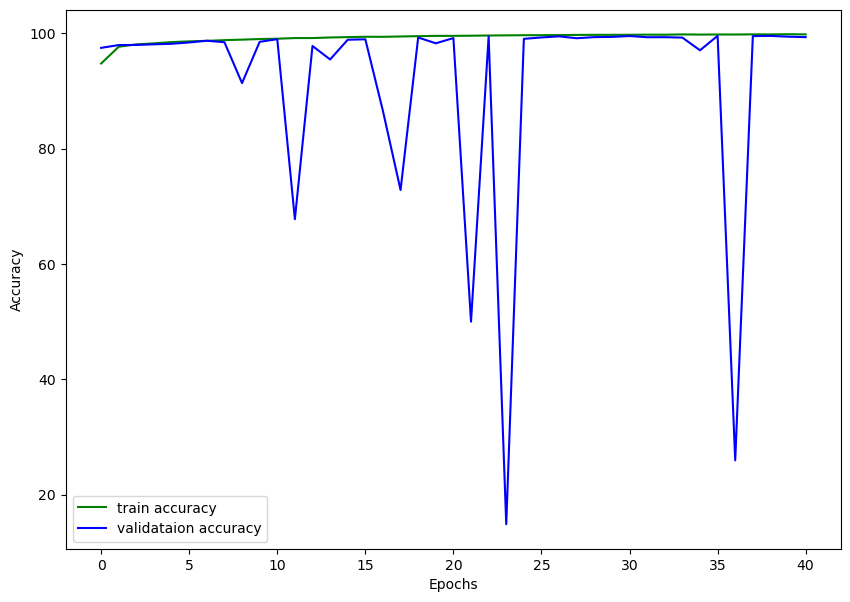

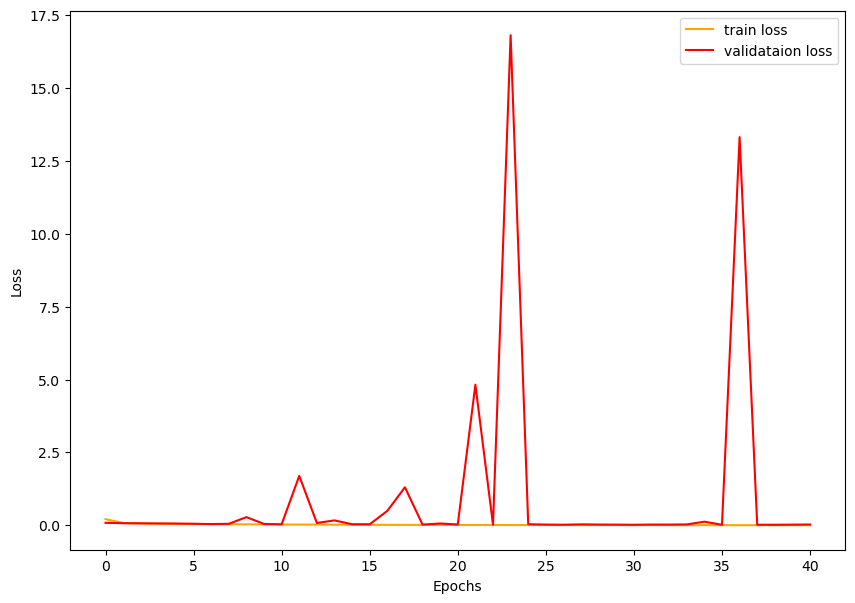

In [26]:
# lists to keep track of losses and accuracies
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
# start the training
for epoch in range(EPOCHS):
    print(f"[INFO]: Epoch {epoch+1} of {EPOCHS}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader, 
                                              optimizer, loss)
    valid_epoch_loss, valid_epoch_acc = validate(model, valid_loader,  
                                                 loss)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)
    torch.save(model.state_dict(), 'models/mathnet/mathnet'+str(epoch)+'.ml')
    
# save the trained model weights
torch.save(model.state_dict(), 'models/mathnet/mathnet.ml')
# save the loss and accuracy plots
save_plots(train_acc, valid_acc, train_loss, valid_loss)
print('TRAINING COMPLETE')

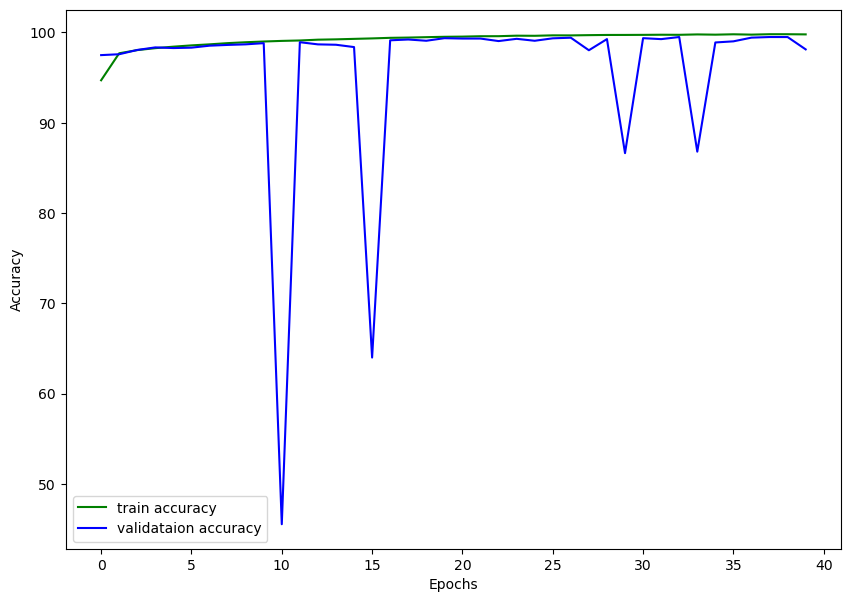

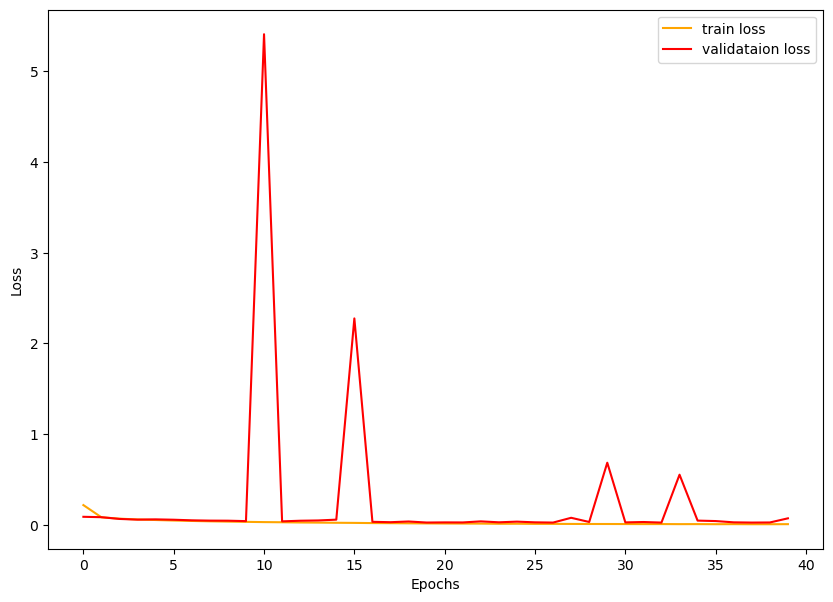

In [32]:
save_plots(train_acc, valid_acc, train_loss, valid_loss)

In [26]:
import cv2
from PIL import Image, ImageOps

img = Image.open("0.jpg")
#print(img.shape)
convert_tensor = transforms.Compose([
    transforms.Resize((28,28)),
    transforms.Grayscale(1),
    transforms.ToTensor()

])        
x_image = convert_tensor(img)

aaa = transforms.ToPILImage()
display(aaa(x_image))

x_image = x_image.unsqueeze(0).float()
x_image = x_image.to(device)

pred = model(x_image) 
print(pred*10, map_pred(pred.argmax().item()))

torch.save(model.state_dict(), 'models/mathnet/mathnet666.ml')

In [ ]:
import cv2
from PIL import Image, ImageOps

m = mnt.MathNet()
m.load_state_dict(torch.load('models/mathnet/mathnet.ml'))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
m = m.to(device)
m.eval()

img = Image.open("0.jpg")
#print(img.shape)
convert_tensor = transforms.Compose([
    transforms.Resize((28,28)),
    transforms.Grayscale(1),
    transforms.ToTensor()

])        
x_image = convert_tensor(img)

aaa = transforms.ToPILImage()
display(aaa(x_image))

x_image = x_image.unsqueeze(0).float()
x_image = x_image.to(device)

pred = m(x_image) 
print(pred*10, map_pred(pred.argmax().item()))